# Integrating the Deep Image Prior on multiple images with the VAE for generating input tensors.

## The idea is that we have some mapping between images and their corresponding latent spaces, which serve as input to the deep image prior.

VAE doesn't need to be perfect at all, just need some logic in place to generate distributions for the "random" input tensors so that we can extend the deep image prior framework to multiple images at a time, and new images

Gets the entire repository in the current Session

In [3]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""

!git clone https://github.com/petersim1/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 2008 (delta 29), reused 26 (delta 9), pack-reused 1950
Receiving objects: 100% (2008/2008), 164.02 MiB | 31.27 MiB/s, done.
Resolving deltas: 100% (211/211), done.


Gets my gdrive into the current session (need this for reading of trained VAE parameters)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
gdrive_path = 'drive/MyDrive/DS-GA-3001/'
vae_modeldict_path = gdrive_path+'VAE_Trained.pth'

In [6]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

from project_extension.VAE import VAE #reads the VAE network

import torch
import torch.optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import DatasetFolder,ImageFolder

from skimage.measure import compare_psnr
from utils.denoising_utils import *

import time

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

imsize =-1

In [7]:
def gen_random_input(mu,sigma,width,depth) :
  '''
  This only reads an image at a time.
  '''
  batch_size = mu.size(0)
  out = torch.zeros((batch_size,depth,mu.size(-1),width))
  for i in range(width) :
    for j in range(depth) :
      out[:,j,:,i] = torch.normal(mu,sigma)
  return out

In [8]:
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """

    loss_list = []

    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        tot_loss = []
        for j in range(100):
            optimizer.zero_grad()
            loss = closure()
            tot_loss.append(loss.item())
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        tot_loss = []
        for j in range(num_iter):
            optimizer.zero_grad()
            loss = closure()
            tot_loss.append(loss.item())
            optimizer.step()

            loss_list.append(loss)
    else:
        assert False

    return tot_loss, loss_list

In [9]:
def add_uniform_noise(img):
  x = np.random.uniform(size = img.shape)
  return x

In [10]:
def add_shuffle_noise(img):
  shape = img.shape
  img = img.flatten()
  np.random.shuffle(img)
  x = img.reshape(shape)
  return x

In [11]:
#Load model
VAE_Model = VAE()
vae_state_dict = torch.load(vae_modeldict_path)
VAE_Model.load_state_dict(vae_state_dict)

<All keys matched successfully>

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [13]:
transform_size = transforms.Compose([
    transforms.ToTensor()
])

loader = ImageFolder('project_extension/vae_train_data',transform_size)

num_images_train = 3

inds = np.arange(len(loader))
np.random.shuffle(inds)

train_inds,test_inds = inds[num_images_train:],inds[:num_images_train]


train_sampler = SubsetRandomSampler(train_inds)
test_sampler  = SubsetRandomSampler(test_inds)

train_loader = DataLoader(dataset=loader,
                          batch_size=num_images_train,
                          sampler=train_sampler)

test_loader = DataLoader(dataset=loader,
                          batch_size=1,
                          sampler=test_sampler)

------------------------------------------------------------
Showing initial images...
------------------------------------------------------------


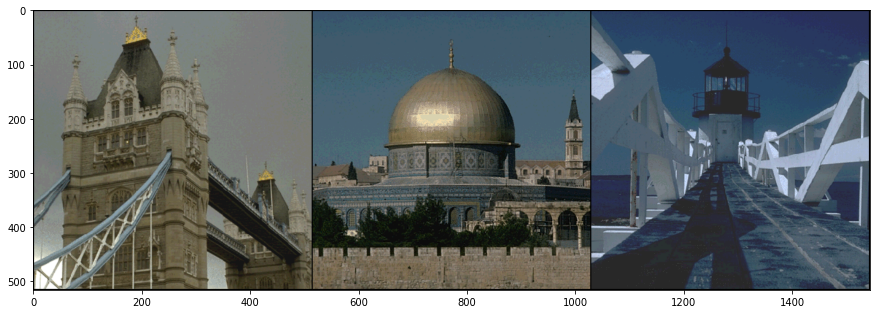

------------------------------------------------------------
Adding noise: 0
------------------------------------------------------------


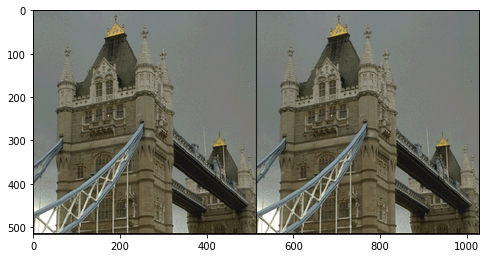

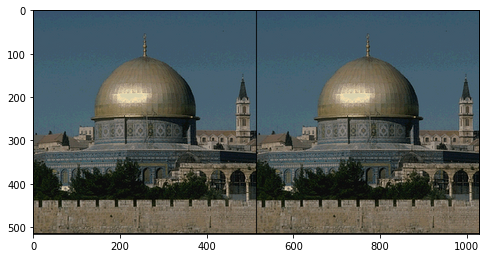

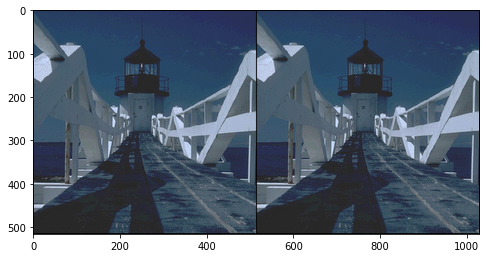

Number of params: 2186619
------------------------------------------------------------
Starting training
------------------------------------------------------------
Starting optimization with ADAM


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noi

Iteration 00000    Loss 0.052953   PSNR_noisy: 12.136344   PSRN_gt: 12.136344 PSNR_gt_sm: 12.136344


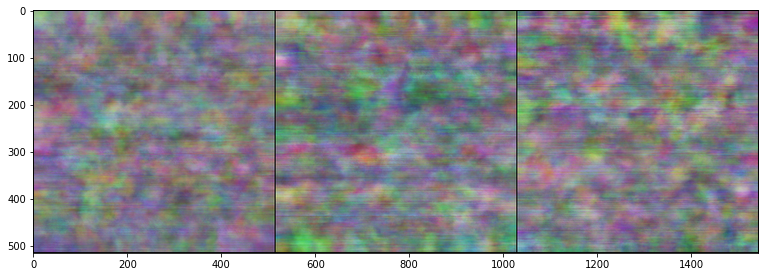

Iteration 05000    Loss 0.000737   PSNR_noisy: 12.691992   PSRN_gt: 12.691992 PSNR_gt_sm: 12.734511


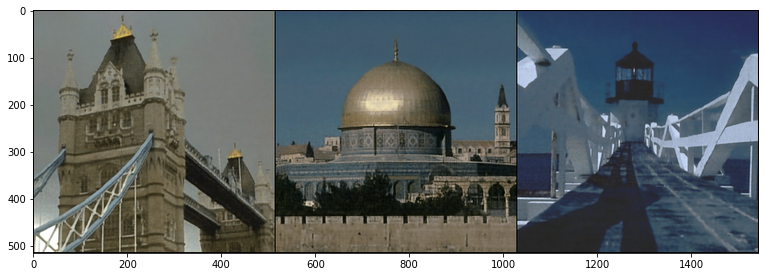

------------------------------------------------------------
Adding noise: 10
------------------------------------------------------------


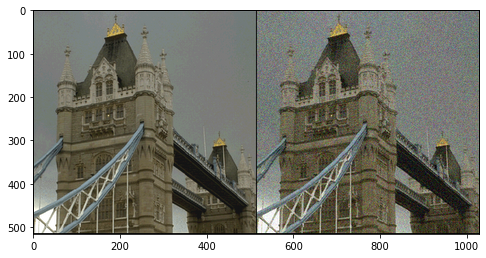

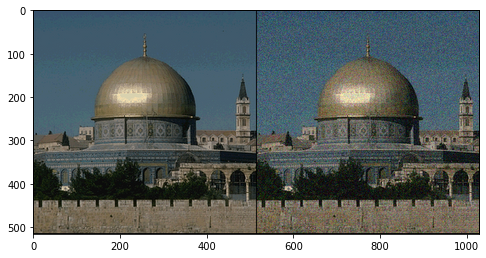

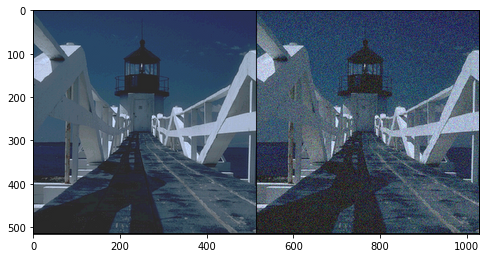

Number of params: 2186619
------------------------------------------------------------
Starting training
------------------------------------------------------------
Starting optimization with ADAM
Iteration 00000    Loss 0.069169   PSNR_noisy: 10.911047   PSRN_gt: 11.424037 PSNR_gt_sm: 11.424037


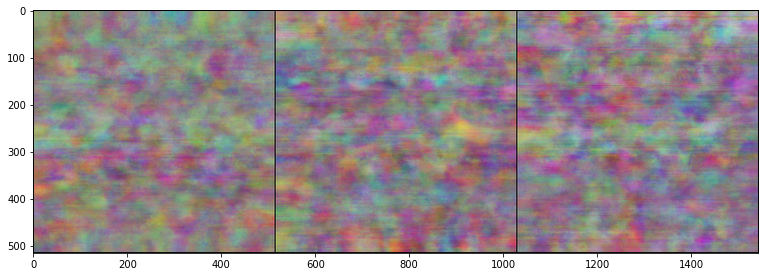

Iteration 05000    Loss 0.008417   PSNR_noisy: 11.816228   PSRN_gt: 12.471892 PSNR_gt_sm: 12.645842


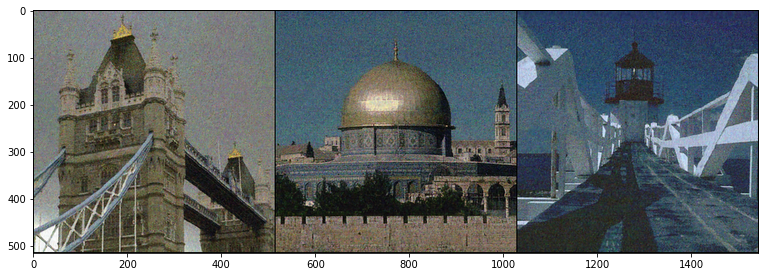

------------------------------------------------------------
Adding noise: shuffle
------------------------------------------------------------


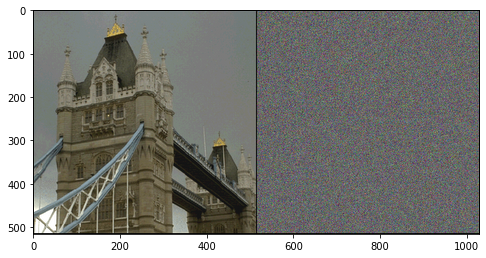

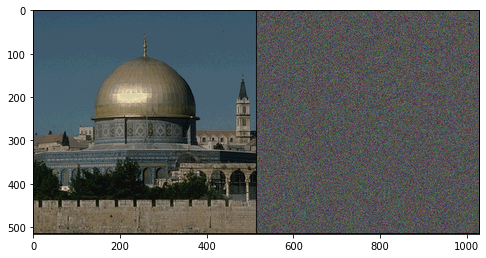

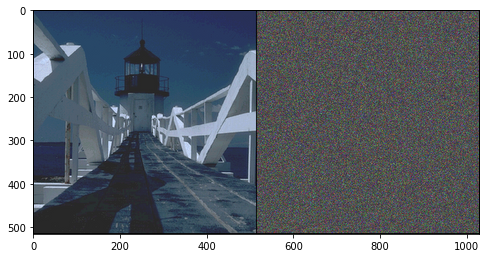

Number of params: 2186619
------------------------------------------------------------
Starting training
------------------------------------------------------------
Starting optimization with ADAM
Iteration 00000    Loss 0.048002   PSNR_noisy: 12.433992   PSRN_gt: 12.785471 PSNR_gt_sm: 12.785471


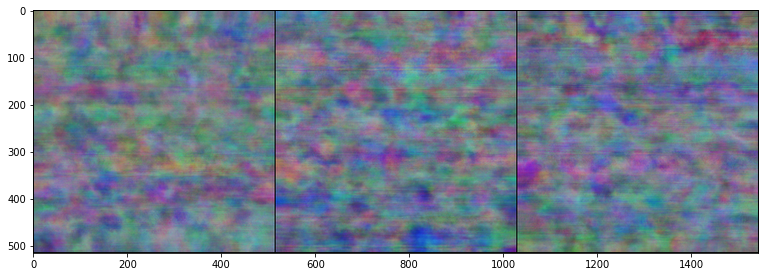

Iteration 05000    Loss 0.015775   PSNR_noisy: 14.225015   PSRN_gt: 14.214434 PSNR_gt_sm: 14.300110


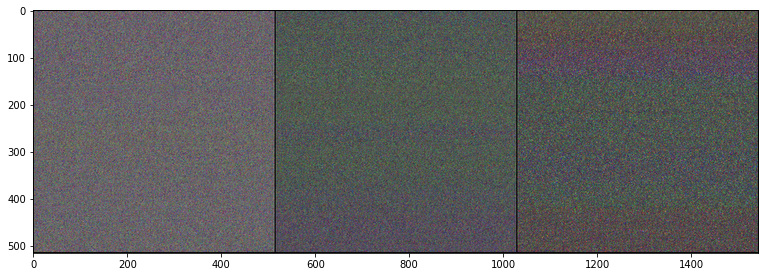

------------------------------------------------------------
Adding noise: uniform
------------------------------------------------------------


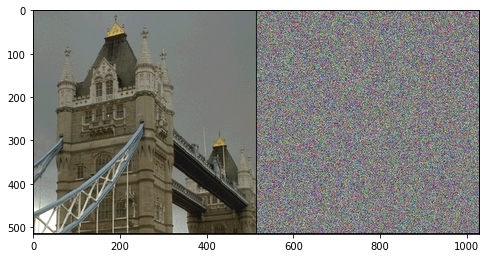

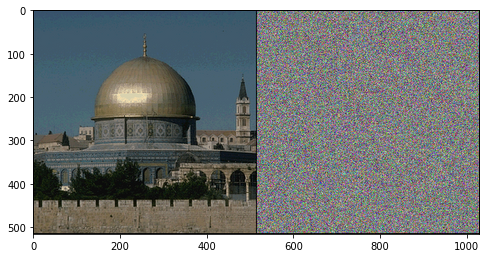

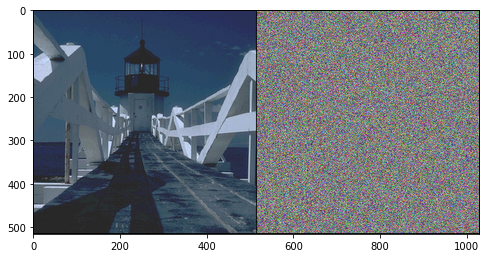

Number of params: 2186619
------------------------------------------------------------
Starting training
------------------------------------------------------------
Starting optimization with ADAM


/usr/local/lib/python3.6/dist-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)


Iteration 00000    Loss 0.092792   PSNR_noisy: 10.390834   PSRN_gt: 12.649177 PSNR_gt_sm: 12.649177


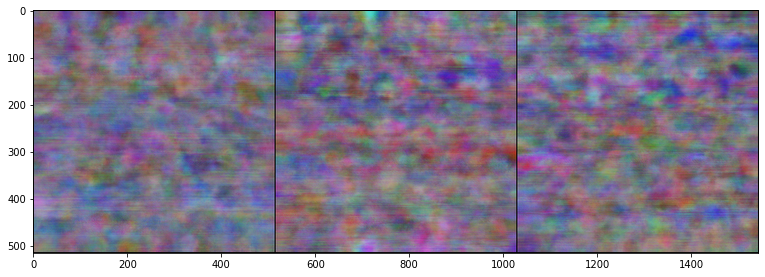

Iteration 05000    Loss 0.042943   PSNR_noisy: 8.915691   PSRN_gt: 9.943007 PSNR_gt_sm: 10.108498


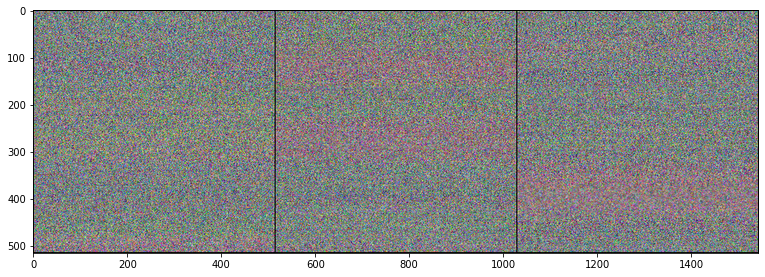

In [14]:
#Loop
sigma_list = [0,10,'shuffle','uniform']
loss_dict = {}

INPUT = 'noise' # 'meshgrid'
noise_type = 'u'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
GENERATE_RANDOM_INPUT = True
PLOT = True

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 5000
exp_weight=0.99

num_iter = 10000
input_depth = 5
width = 512
figsize = 10

#Get images
print(60*"-")
print("Showing initial images...")
print(60*"-")

img,_ = next(iter(train_loader))
grid_img = torchvision.utils.make_grid(img, nrow=num_images_train)

plt.figure(figsize=(15,6))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

for sigma in sigma_list:

  #Add noise to images
  img_nps, img_noisy_nps = [],[]

  print(60*"-")
  print("Adding noise:",str(sigma))
  print(60*"-")
  time.sleep(0.5)

  for im in img :
      img_np = im.numpy()

      if isinstance(sigma, int):
        sigma_ = sigma/100.
        _, img_noisy_np = get_noisy_image(img_np, sigma_)
      elif sigma == 'shuffle':
        img_noisy_np = add_shuffle_noise(img_np)
      elif sigma == 'uniform':
        img_noisy_np = add_uniform_noise(img_np)
      else:
        assert False
      if PLOT:
          plot_image_grid([img_np, img_noisy_np], 4, 6);

      img_nps.append(img_np)
      img_noisy_nps.append(img_noisy_np)

  net = get_net(input_depth, 'skip', pad,
            skip_n33d=128, 
            skip_n33u=128, 
            skip_n11=4, 
            num_scales=5,
            upsample_mode='bilinear').type(dtype)


  img_out,mu,logvar = VAE_Model(img)

  # New Custom function to generate "random" inputs.
  if GENERATE_RANDOM_INPUT:
    net_inputs = gen_random_input(mu,logvar.mul(0.5).exp_(),width,input_depth).type(dtype).detach()
  else:
    net_inputs = gen_fixed_input(mu,logvar.mul(0.5).exp_(),width,input_depth).type(dtype).detach()


  # Compute number of parameters
  s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
  print ('Number of params: %d' % s)

  # Loss
  mse = torch.nn.MSELoss().type(dtype)

  # Convert noisy images to tensors. In minibatch format. These are "target" images.
  img_noisy_torches = torch.from_numpy(np.array(img_noisy_nps)).type(dtype)

  net_input_saved = net_inputs.detach().clone()
  noise = net_inputs.detach().clone()
  out_avg = None
  last_net = None
  psrn_noisy_last = 0

  def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
  
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_inputs)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torches)
    total_loss.backward()
        
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    #print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),end='\n')
    if  PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),end='\n')
        out_np = out.detach().cpu().numpy()
        #plot_image_grid([np.clip(out_np, 0, 1), 
        #                 np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        plot_image_grid([*np.clip(out_np, 0, 1)], factor=figsize, nrow=num_images_train)

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')#
    
            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss


  print(60*"-")
  print("Starting training")
  print(60*"-")

  i = 0
  p = get_params(OPT_OVER, net, net_inputs)
  losses,loss_list = optimize(OPTIMIZER, p, closure, LR, num_iter)   
  loss_dict[sigma] = loss_list
  time.sleep(4)



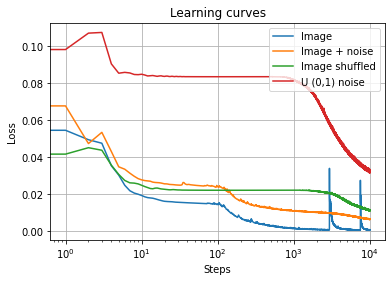

In [15]:
#Plot learning curves

name_dict = {
              0:'Image',
              10: 'Image + noise',
              'shuffle': 'Image shuffled',
              'uniform' : 'U (0,1) noise'
}

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning curves")
for sigma in sigma_list:
    plt.plot([val for val in loss_dict[sigma]],label = name_dict[sigma])
plt.legend(loc = 'upper right')
plt.xscale('log')
plt.grid()
plt.show()